In [18]:
import os
import random
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, ELU
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation
from keras import models
from keras.models import load_model
from sklearn.metrics import confusion_matrix

In [35]:
def create_train_test_folders(folder_path, train_folder_name, test_folder_name, train_split=0.7):

    for emotion_folder in os.listdir(folder_path):
        # Create train and test subfolders for each emotion folder
        train_subfolder_path = os.path.join(train_folder_name, emotion_folder)
        test_subfolder_path = os.path.join(test_folder_name, emotion_folder)
        os.makedirs(train_subfolder_path, exist_ok=True)
        os.makedirs(test_subfolder_path, exist_ok=True)

        # Get list of images in the current emotion folder
        image_list = os.listdir(os.path.join(folder_path, emotion_folder))
        random.shuffle(image_list)

        # Split the images into training and testing sets
        train_size = int(len(image_list) * train_split)
        train_images = image_list[:train_size]
        test_images = image_list[train_size:]

        # Move the training images to the train subfolder
        for image_name in train_images:
            source_path = os.path.join(folder_path, emotion_folder, image_name)
            destination_path = os.path.join(train_subfolder_path, image_name)
            shutil.copyfile(source_path, destination_path)

        # Move the testing images to the test subfolder
        for image_name in test_images:
            source_path = os.path.join(folder_path, emotion_folder, image_name)
            destination_path = os.path.join(test_subfolder_path, image_name)
            shutil.copyfile(source_path, destination_path)

    print("Train and test folders created successfully!")


In [36]:
def display_train_images(train_folder_path, emotion_folder):
    
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    axs = axs.ravel()
    train_images = []
    # Get list of images in the specified emotion folder
    image_list = os.listdir(os.path.join(train_folder_path, emotion_folder))
    # Choose 6 random images from the list
    random_images = random.sample(image_list, 6)
    for image_name in random_images:
        # Load the image and append it to the train_images list
        image_path = os.path.join(train_folder_path, emotion_folder, image_name)
        train_images.append(mpimg.imread(image_path))

    # Display the 6 randomly chosen images
    for i, image in enumerate(train_images):
        axs[i].imshow(image,  cmap='gray')
        axs[i].set_title(emotion_folder + " " + str(i+1))
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

In [37]:
def train_model(train_folder_path, test_folder_path):
    train_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_folder_path,
        target_size=(48, 48),
        batch_size=128,
        color_mode='grayscale',
        class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(
        test_folder_path,
        target_size=(48, 48),
        batch_size=128,
        color_mode='grayscale',
        class_mode='categorical')

    model = Sequential()

    # 1 - Convolution
    model.add(Conv2D(64,(3,3), padding='same', input_shape=(56, 56,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 2nd Convolution layer
    model.add(Conv2D(128,(5,5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 3rd Convolution layer
    model.add(Conv2D(512,(3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 4th Convolution layer
    model.add(Conv2D(512,(3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Flattening
    model.add(Flatten())

    # Fully connected layer 1st layer
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    # Fully connected layer 2nd layer
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(train_generator.num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)
    
    model.fit(train_generator, 
              steps_per_epoch=train_generator.n // train_generator.batch_size, 
              epochs=50, 
              validation_data=validation_generator, 
              validation_steps=validation_generator.n // validation_generator.batch_size, 
              callbacks=[early_stop])

    return model


In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [55]:
def prediction(test_folder_path, model):
   
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    validation_generator = test_datagen.flow_from_directory(
        test_folder_path,
        target_size=(48, 48),
        batch_size=128,
        color_mode='grayscale',
        class_mode='categorical')
    
    predictions = model.predict_generator(generator=validation_generator)
    y_pred = [np.argmax(probas) for probas in predictions]
    y_test = validation_generator.classes
    class_names = list(validation_generator.class_indices.keys())
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm, cmap='PuBuGn')
    ax.grid(False)
    ax.set_xlabel('Predicted labels', fontsize=12, color='black')
    ax.set_ylabel('True labels', fontsize=12, color='black')
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, fontsize=10, color='black')
    ax.set_yticklabels(class_names, fontsize=10, color='black')
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
    
    plt.show()
    
    return y_pred, y_test, class_names
    

In [8]:
create_train_test_folders("C:\\Users\\Ankit\\Desktop\\DNN Facial Expression\\images", 'train', 'test')

Train and test folders created successfully!


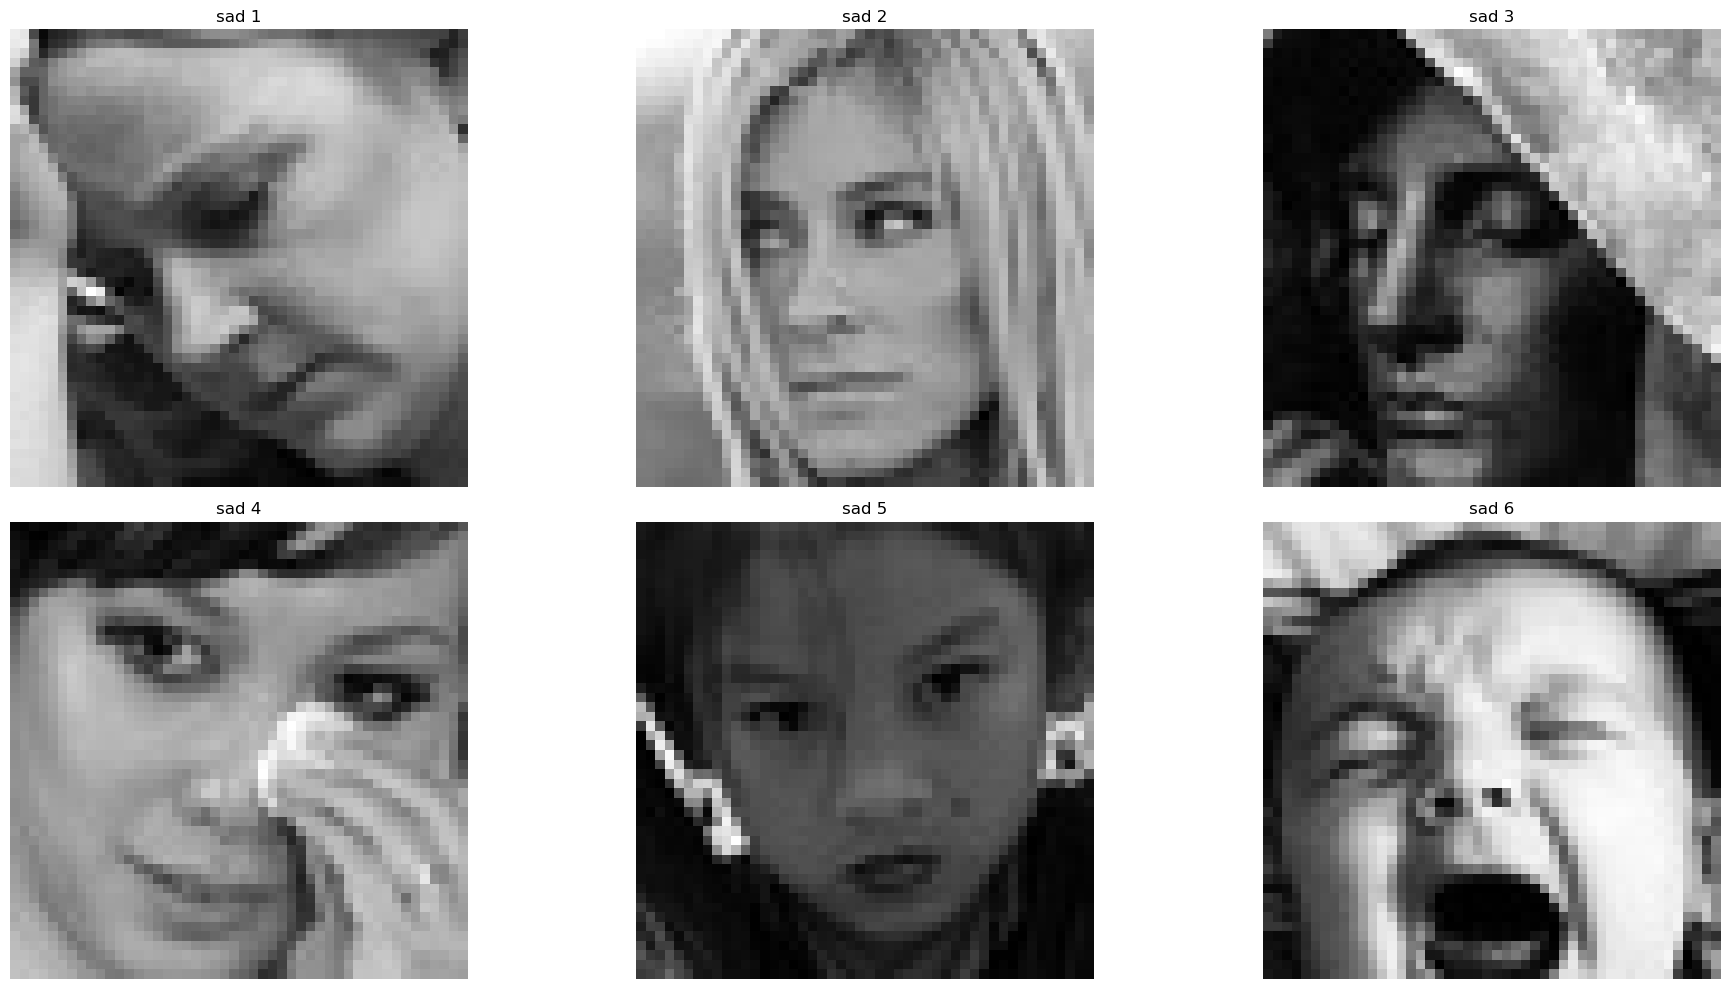

In [26]:
display_train_images("C:\\Users\\Ankit\\Desktop\\DNN Facial Expression\\images", 'sad')

In [38]:
starttime = datetime.datetime.now()

model = train_model("C:\\Users\\Ankit\\Desktop\\DNN Facial Expression\\train", "C:\\Users\\Ankit\\Desktop\\DNN Facial Expression\\test")

endtime = datetime.datetime.now()
totalTime = endtime - starttime
print(f"Model fitting took {totalTime.total_seconds()} seconds.")

plot_loss(model)

Found 16451 images belonging to 4 classes.
Found 4115 images belonging to 4 classes.
Epoch 1/50
128/128 [==============================] - 328s 3s/step - loss: 1.2812 - accuracy: 0.4248 - val_loss: 1.1791 - val_accuracy: 0.4368
Epoch 2/50
128/128 [==============================] - 317s 2s/step - loss: 1.0596 - accuracy: 0.5267 - val_loss: 1.2075 - val_accuracy: 0.4888
Epoch 3/50
128/128 [==============================] - 317s 2s/step - loss: 0.8836 - accuracy: 0.6120 - val_loss: 1.0403 - val_accuracy: 0.5393
Epoch 4/50
128/128 [==============================] - 317s 2s/step - loss: 0.7729 - accuracy: 0.6695 - val_loss: 0.9011 - val_accuracy: 0.5898
Epoch 5/50
128/128 [==============================] - 319s 2s/step - loss: 0.6996 - accuracy: 0.7080 - val_loss: 0.7173 - val_accuracy: 0.6963
Epoch 6/50
128/128 [==============================] - 318s 2s/step - loss: 0.6449 - accuracy: 0.7286 - val_loss: 0.7429 - val_accuracy: 0.6907
Epoch 7/50
128/128 [==============================] - 318

In [39]:
model.save("C:\\Users\\Ankit\\Desktop\\DNN Facial Expression\\my_model.h5")

Found 4115 images belonging to 4 classes.


C:\Users\Ankit\AppData\Local\Temp\ipykernel_14988\3595887944.py:12: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(generator=validation_generator)


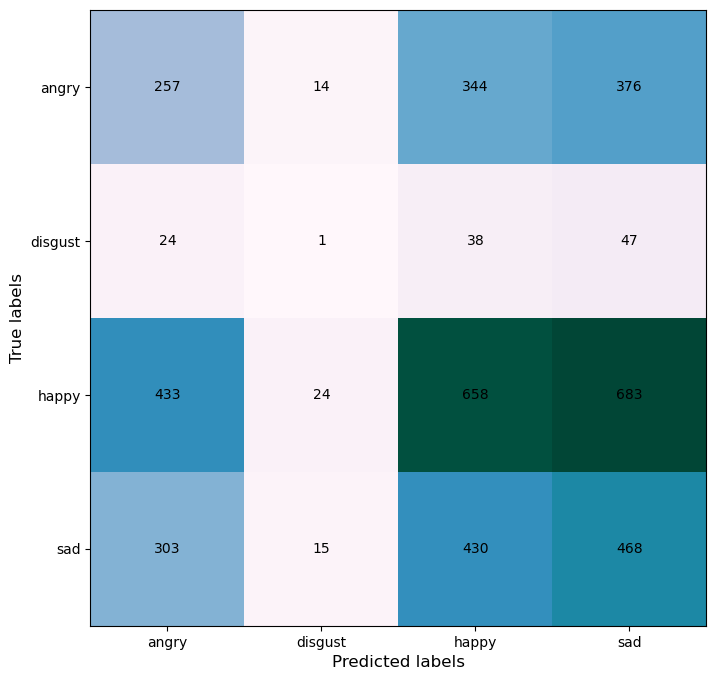

In [56]:
model = load_model("C:\\Users\\Ankit\\Desktop\\DNN Facial Expression\\my_model.h5")
y_pred, y_test, class_names = prediction("C:\\Users\\Ankit\\Desktop\\DNN Facial Expression\\test", model)

In [50]:
import cv2
import numpy as np
from keras.models import load_model

# Load the trained model
model = load_model("C:\\Users\\Ankit\\Desktop\\DNN Facial Expression\\my_model.h5") # Replace "my_model.h5" with the name of your trained model file

# Define the mapping of class labels to emotion names
emotion_map = {0: "angry", 1: "disgust", 2: "happy", 3: "sad"}

# Load the image and preprocess it
img = cv2.imread("C:\\Users\\Ankit\\Desktop\\DNN Facial Expression\\test3.jpg") # Replace "path/to/image.jpg" with the path to your local image file
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (56, 56))
img = np.expand_dims(img, axis=-1)
img = np.expand_dims(img, axis=0)
img = img / 255.0

# Make a prediction
predictions = model.predict(img)
predicted_class = np.argmax(predictions)

# Print the predicted emotion
predicted_emotion = emotion_map[predicted_class]
print(predicted_emotion)


1/1 [==============================] - 0s 230ms/step
happy
